In [199]:
# loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette("coolwarm")
plt.style.use('ggplot')

from scipy import stats
from statsmodels.stats.stattools import durbin_watson

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, plot_importance
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets

import warnings
warnings.filterwarnings('ignore')

## Introduction

This project utilizes a variety of linear regression algorithms in order to predict the housing price in the city of Boston, or `MEDV`. These are all of the variables in the dataset. This data is maintained in the `datasets` module of `sklearn` but it can also be found online on the UCI Machine Learning Repository or from Kaggle.com. 

    CRIM - per capita crime rate by town
    ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
    INDUS - proportion of non-retail business acres per town.
    CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
    NOX - nitric oxides concentration (parts per 10 million)
    RM - average number of rooms per dwelling
    AGE - proportion of owner-occupied units built prior to 1940
    DIS - weighted distances to five Boston employment centres
    RAD - index of accessibility to radial highways
    TAX - full-value property-tax rate per \$10,000
    PTRATIO - pupil-teacher ratio by town
    B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    LSTAT - % lower status of the population
    MEDV - Median value of owner-occupied homes in $1000s
    
So first we will read in the data. 

In [200]:
# loading data
boston = datasets.load_boston()
df = pd.DataFrame(boston.data, columns = boston.feature_names)
df['MEDV'] = boston.target

First we can look at the first few observations and also check for any missing values. 

In [201]:
# Looking at the top of the dataset
print(df.head())
# Checking for missing values
print(df.isnull().any())
print(df.shape)

       CRIM    ZN  INDUS  CHAS   NOX    RM   AGE   DIS  RAD    TAX  PTRATIO  \
0  6.32e-03  18.0   2.31   0.0  0.54  6.58  65.2  4.09  1.0  296.0     15.3   
1  2.73e-02   0.0   7.07   0.0  0.47  6.42  78.9  4.97  2.0  242.0     17.8   
2  2.73e-02   0.0   7.07   0.0  0.47  7.18  61.1  4.97  2.0  242.0     17.8   
3  3.24e-02   0.0   2.18   0.0  0.46  7.00  45.8  6.06  3.0  222.0     18.7   
4  6.91e-02   0.0   2.18   0.0  0.46  7.15  54.2  6.06  3.0  222.0     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  
CRIM       False
ZN         False
INDUS      False
CHAS       False
NOX        False
RM         False
AGE        False
DIS        False
RAD        False
TAX        False
PTRATIO    False
B          False
LSTAT      False
MEDV       False
dtype: bool
(506, 14)


So note that there are no missing variables, although it should be noted that the `CHAS` and `RAD` variables are categorical rather than continuous variables. 

### Data Visualization
As an introductory step it is good to visualize the response variable against the target variables. 

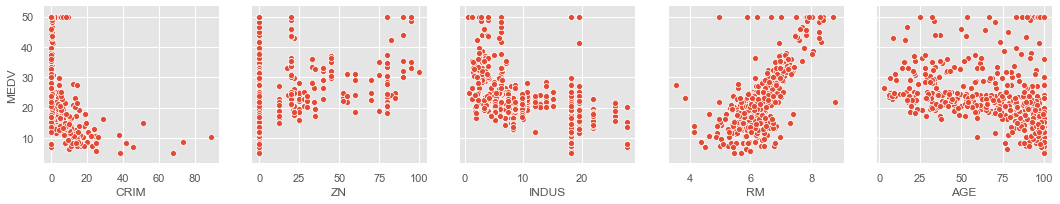

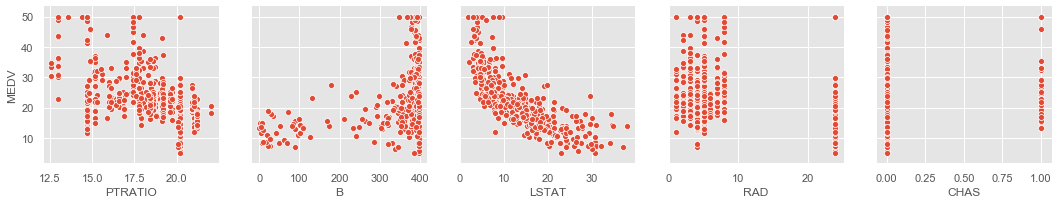

In [202]:
# response vs the continuous target variables
sns.pairplot(data = df, height = 3,
             y_vars = ['MEDV'],
             x_vars = ['CRIM', 'ZN', 'INDUS', 'RM', 'AGE'])

sns.pairplot(data = df, height = 3, y_vars = ['MEDV'],
            x_vars = ['PTRATIO', 'B', 'LSTAT', 'RAD', 'CHAS'])

A cursory glance at the scatterplots of the response and target variables show that `RM` and `LSTAT` have something of a linear relationship with `MEDV`. The rest of the variables don't seem to show much of a correlation. We can scrutinize this further by looking at a correlation matrix. This will help us determine which features to include in the final model, a process known as _feature selection_.

## Feature Selection

### Correlation Matrix
This will tell us if any of the features are highly correlated with one another, which is bad since one of the assumptions of regression is that the features are independent from one another. We can also look at how the response variable correlates with the features. 

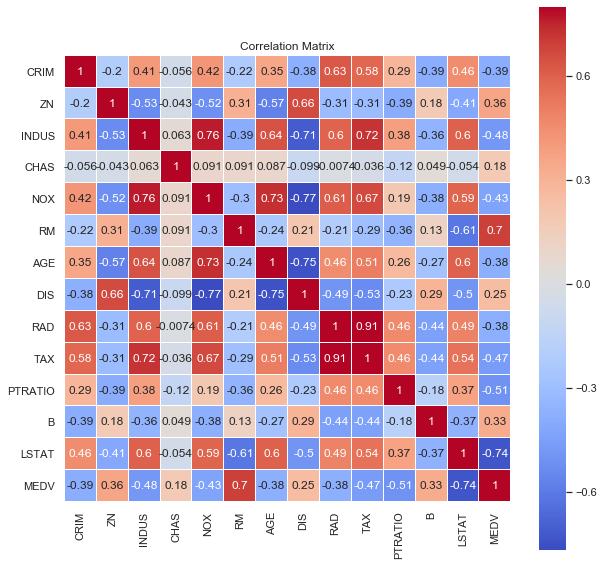

In [203]:
# Setting style for seaborn
sns.set_context("notebook")
sns.set_style("darkgrid")

# 2 significant figures
pd.set_option('precision', 2)

# Correlation matrix
corr = df.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, vmax = .8, linewidths = 0.01, square = True, annot = True, cmap = 'coolwarm', linecolor = 'white')
plt.title('Correlation Matrix')
plt.show()

As we expected from our graphs, we notice that the features that correlate the highest with `MEDV` are `RM`, the average number of rooms, and `LSTAT`, the percent lower status of the population.

`DIS`, which is weighted distances to Boston's employment centers, has a strong negative correlation with 3 variables: `INDUS`, the proportion of non-business acres, `NOX`, the concentration of nitric oxides,  and `AGE`, the proportion of homes built before 1940.

### Multicollinearity
In building regression models we don't want to have highly correlated features, otherwise known as _multicollinearity_. Multicollinearity can result in inaccurate estimations of the regression coefficients, give false p-values when conducting tests, and worst of all, degrade the predictability of the model, among other problems.

In general when building a model you want to have something less complex (i.e. less features) to reduce overfitting and correlated features tend to give similar information about the response variable. Therefore I am going to check which features have excessive correlation with the other features (> 0.75) and drop them from the dataset. 

In [204]:
# Assigning the response variable as y and the target variables as X
y = df['MEDV']
X = pd.DataFrame(boston.data, columns = boston.feature_names)

# drop features that are highly correlated with other features
# matrix of absolute values of correlation
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
print(to_drop)

['NOX', 'DIS', 'TAX']


It appears that `NOX`, `DIS`, and `TAX` are highly correlated with one another so I am going to drop them from the dataset.

In [205]:
# drop the highly correlated features
X = X.drop(X[to_drop], axis = 1)
X.head()

,CRIM,ZN,INDUS,CHAS,RM,AGE,RAD,PTRATIO,B,LSTAT
0,6.32e-03,18.0,2.31,0.0,6.58,65.2,1.0,15.3,396.90,4.98
1,2.73e-02,0.0,7.07,0.0,6.42,78.9,2.0,17.8,396.90,9.14
2,2.73e-02,0.0,7.07,0.0,7.18,61.1,2.0,17.8,392.83,4.03
3,3.24e-02,0.0,2.18,0.0,7.00,45.8,3.0,18.7,394.63,2.94
4,6.91e-02,0.0,2.18,0.0,7.15,54.2,3.0,18.7,396.90,5.33


Now that we've taken care of that, we want to look at the distribution of the response variable, `MEDV`, by visualizing it in a histogram and a normal probability plot.

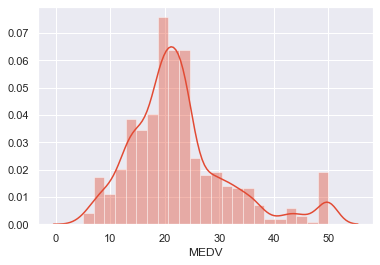

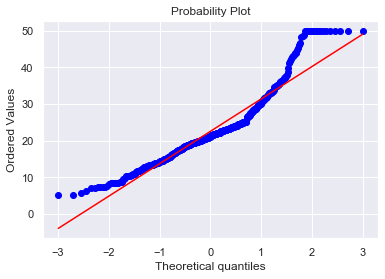

In [206]:
# histogram and normal probability plot
sns.distplot(y, hist = True)
fig = plt.figure()
res = stats.probplot(y, plot = plt)

Notice how the response variable doesn't strictly follow a Normal distribution as it should. Having said that, with such a large sample size of 506, we can forgo this assumption in favor of the Central Limit Theorem which stipulates that the data conforms to a Normal distribution at a large enough sample size.

### Assumptions

To be able to apply linear regression analysis, we have to ensure that the assumptions are fulfilled. These are as follows: 

1. Linearity of the residuals
2. Independence of the residuals
3. Normality of the residuals with a mean of 0
4. Homoskedasticity of the residuals

#### Normality
Now let's look at the distributions of these two variables to see if they follow a Normal distribution. We can also conduct a Shapiro-Wilk test, which tests the null hypothesis that the data is from a Normal distribution. The test returns a W-statistic, which itself has a p-value. If the p-value of the test statistic is below our alpha level of 0.05, then we reject the null hypothesis and conclude that the data is not from a Normal distribution. 

##### The Central Limit Theorem
It is important to point out that while Normality is an assumption, even when it is violated it doesn't necessarily invalidate the model. It is commonly understood that non-Normal residuals is fairly typical in the "real world" and the Central Limit Theorem (which stipulates that data conforms to a Normal distribution at a large enough sample size, generally $n > 15$) generally takes precedence. 

#### Multicollinearity
The third assumption has to do with multicollinearity. We already established early on that several other variables had correlation with one another and dropped those features, and `LSTAT` and `RM` had a moderate correlation coefficient of $-0.61$, which we don't think is enough to consider them multicollinear. 

#### Independent Residuals
Next we need to check that the residuals of the data are independent from each other. Another way to describe this would be autocorrelation of the residuals. We can test this with a Durbin-Watson test. If the test statistic of the test is between 1.5 and 2.5, then there is little to no autocorrelation. Below 2 is considered positive autocorrelation and above 2 is considered negative autocorrelation. 2 would mean no autocorrelation at all. 

#### MSE and R-squared
In predicting for continuous variables such as in linear regression, you have a few different metrics to quantify the strength and accuracy of your model. The first is the _Mean Squared Error_, or MSE. It is one of a few 'loss' functions used to quantify the strength of a regression model. It is effectively the average of the squares of the errors, or 

$$MSE = \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

where $y_i$ is the true value of the response variable given input $X_i$ and $\hat{y}_i$ is the predicted value. It quantifies how far away the predictions are from the true values, and the closer it is to zero, the better. 

_R-squared_ ($R^2$), otherwise known as the coefficient of determination, is the percentage of the variation in the response that is explained by the model, hence it is always between 0 and 1, where 1 means that 100% of the variation in the response is explained by the model. 

After splitting and scaling the data, we can put together a function that builds the model, fits it, calculates the evaluation metrics like the MSE and R-squared, and tests the assumptions. 

#### Training/Test Split
In order to build our model and test it, we do a split of the data between a training set and a test set. Basically when fitting a model, you "train" it on the training set (typically a much bigger subset of the data), then apply the model to the test set. Essentially the model looks at what values for $X$ (target variable(s)) return what values for $y$ (response variable) in the training set, then uses the test set of $X$ values to make predictions for $y$. Then to evaluate the model, we compare the predictions that the model made ($\hat{y}$) against the true values of $y$ (the test set). 

#### Cross-Validation and Parameter Tuning
Cross validation is the process of training learners using one set of data, and testing it using a different set. While there are different kinds of cross-validation methods, we are using k-fold cross validation. In this case, the dataset is divided into $k$ subsets (or folds) and each fold is used as a test set with the rest used as a training set. Then the average errors across all $k$ trials is computed. The variance is reduced the higher $k$ is, but obviously this can get rather computationally expensive once you get into larger datasets and high values of $k$. 

It is important to distinguish that this train/test split during cross-validation is distinct from the train/test split of the data that happens in the initial data preparation process. In this case, the training data (80% of the dataset) is split into $k$ folds to be trained and tested on, and later the optimized, cross-validated model is tested on the 20% of test data we set aside at the beginning. This test data is always to be kept separate in the model training process to reduce overfitting. 

Parameter tuning is the process of selecting the values for a model's parameters that maximize the model's accuracy. The function `GridSearchCV` (from `sklearn.model_selection`) uses 3-fold cross validation by default and tests a number of different values for the parameters of a model, such as the number of estimators. We can use it to choose the optimal parameters for each of the models we are going to fit. 

#### Variable Importance
Some of the models we are going to fit have a `feature_importance` attribute that allows us to visualize the varying strengths of each feature on the model itself. This can help us determine which features are most crucial in predicting the response, and maybe even build a smaller model based on those crucial features.

In previous runs of this code I had checked the variable importance of the 'full' model which used all the available variables, minus the ones that were collinear. It ended up that `RM` and `LSTAT` were the most important variables in all of the models, so I decided to try a model that only uses those two variables. This makes sense since these were the two variables that had a significant correlation with the response variable. 

In [207]:
# Data Preparation
X = X[['RM', 'LSTAT']]
# split between training and testing sets, (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

# scaling the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [208]:
# function that finds the mean of the residuals, tests for Normality and independence

def residual_tests(residuals):
    
    # Mean of the residuals
    residuals_mean = round(np.mean(residuals), 3)
    print("{} is the mean of the residuals.".format(residuals_mean))
    
    # Checking for Normality of the residuals, Shapiro-Wilk test
    W_stat, p = stats.shapiro(residuals)
    W_stat = round(W_stat, 3)
    p = round(p, 3)
    print("{} is the test-statistic for the Shapiro-Wilk test with a p-value of {}.".format(W_stat, p))
    if p < 0.05: 
        print("We conclude that the residuals are not Normally distributed.")
    else:
        print("We conclude that the residuals are Normally distributed.")
    
    # Checking independence of the residuals, Durbin-Watson test
    dw = round(durbin_watson(residuals), 3)
    print("{} is the test-statistic for the Durbin-Watson test.".format(dw))
    if dw > 2.5 and dw <= 4:
        print("We conclude there is strong negative autocorrelation in the residuals.")
    if dw > 0 and dw < 1.5:
        print("We conclude there is strong positive autocorrelation in the residuals.")
    else:
        print("We conclude there is little to no autocorrelation in the residuals and therefore they are independently distributed.")

In [209]:
# function that plots the predicted values against the true values, the residual plot, and the QQ-plot of the residuals
# requires seaborn and matplotlib.pyplot

def plot_model_diagnostics(y_pred, y_test, residuals):
    
    # Predictions vs True Values
    plt.figure()
    sns.regplot(x = y_pred, y = y_test, ci = None, scatter_kws = {'color': 'b'}, line_kws = {'color': 'r'})
    plt.xlabel('Predictions')
    plt.ylabel('True Values')
    plt.title("Predictions vs True Values")
    
    # Residual Plot
    plt.figure()
    sns.residplot(x = y_pred, y = y_test, lowess = True, scatter_kws = {'color': 'b'}, line_kws = {'color': 'r'})
    plt.title("Residual Plot")
    
    # QQ-plot
    plt.figure()
    stats.probplot(residuals, plot = plt)
    plt.title("QQ-plot of the Residuals")

In [ ]:
# function to plot variable importance, only works for estimators with feature_importances_ attribute

def plot_variable_importance(model):
    
    importances = model.best_estimator_.feature_importances_

    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Rearrange feature names so they match the sorted feature importances
    names = list(X.columns.values)
    names = [names[i] for i in indices]
    
    # Create plot
    plt.figure()
    plt.title("Feature Importance")
    plt.bar(range(X_train.shape[1]), importances[indices])
    plt.xticks(range(X_train.shape[1]), names, rotation=90)
    plt.show()

#### Linear Regression
First we will start with the simplest of machine learning algorithms, the linear regression model. We use the function to fit the model and test it against the assumptions, so that we can evaluate the strength of the model within context. We can also help diagnose model issues by plotting the predictions against the true values and plot the residuals as well.

The implementation of multiple linear regression with multiple features (independent variables) appears like so:

$$ y = \beta_0 + \beta_1x_1 + ... + \beta_nx_n $$ 

Where $y$ is the response, $x_i$ is the feature (or input variable), $\beta_0$ is the intercept, and $\beta_1$ through $\beta_n$ are the coefficients for each of the $n$ independent variables.

In [ ]:
# Linear Regression Model
regr_LR = LinearRegression()

# Hyper-parameter tuning
parameters_LR = {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]}
grid_LR = GridSearchCV(estimator = regr_LR, param_grid = parameters_LR)
model_LR = grid_LR.fit(X_train, y_train)
predictions_LR = model_LR.predict(X_test)

# MSE 
mse_LR = round(mean_squared_error(y_test, predictions_LR), 3)
print("{} is the Mean Squared Error.".format(mse_LR))

# R-squared
r2_LR = round(model_LR.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_LR))
    
# Residuals
residuals_LR = y_test - predictions_LR
residual_tests(residuals_LR)

# Plotting
plot_model_diagnostics(predictions_LR, y_test, residuals_LR)

We see that the mean of the residuals is approximately zero and that they are also independently distributed. Although the residuals of the model are not from a Normal distribution based on our tests and this QQ-plot, the sample size (504) is sufficiently large enough for us to bypass this assumption. In practice, residuals seldom fulfill this requirement. 

Looking at the residual plot however, we see a trend in how they are distributed (note the curve in the red line). Ideally this red line would be as horizontal as possible. Note the imbalance on the Y-axis with how the residuals are distributed. These all point towards the conclusion that this model might not be the strongest. 

### Decision Tree

Decision trees are a simple machine learning model that can be utilized for classification and also for regression, which is our use case. The algorithm works in much the same way it does for a classification problem as it does for regression, where it chooses a label. In the regression case, it chooses between 'leaves' which are the splits in the data. 

For example, suppose in our training set we have values for $x$ ranging from 1-100, and each value for $x$ corresponds to a value for $y$. The algorithm can split these values  into ranges, such as 1-25, 25-50, 50-75, 75-100. It will then take a value for $y$ that represents that range for $x$. 

In [ ]:
# Decision Tree Regression
regr_DT = DecisionTreeRegressor(random_state = 10)

# Hyper-parameter tuning
parameters_DT = {'max_features': ['sqrt', 'log2', None], 'max_depth': range(2,20)}
grid_DT = GridSearchCV(estimator = regr_DT, param_grid = parameters_DT)
model_DT = grid_DT.fit(X_train, y_train)
predictions_DT = model_DT.predict(X_test)

# MSE 
mse_DT = round(mean_squared_error(y_test, predictions_DT), 3)
print("{} is the Mean Squared Error.".format(mse_DT))

# R-squared
r2_DT = round(model_DT.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_DT))
    
# Residuals
residuals_DT = y_test - predictions_DT
residual_tests(residuals_DT)

# Plotting
plot_model_diagnostics(predictions_DT, y_test, residuals_DT)

# Plotting variable importance
plot_variable_importance(model_DT)

### Random Forest
Random forest is a machine learning algorithm that, true to its name, utilizes decision trees. It is a bootstrap aggregation (bagging) method that leverages many decision trees. This ensemble learning technique helps minimize overfitting which is a problem common when utilizing decision trees. It also introduces an element of randomness that makes it more robust. 

While Random Forests, like decision trees, can be utilized for classification, this is a regression problem since we are predicting a continuous response variable rather than a categorical one. 

It works by sampling multiple subsamples (with replacement) from the training dataset, then trains many decision trees for regression, where each leaf node outputs the mean of all of the label values in the node itself. The "forest" then returns the average of the predictions of all of the decision trees. 

While the randomness and scale of the algorithm makes it effectively reduce overfitting, it suffers from a lack of interpretability, making it a 'black-box' algorithm. 

In [ ]:
# Random Forest Regressor
regr_RF = RandomForestRegressor()

# Hyper-parameter tuning
parameters_RF = {'n_estimators': [10, 20, 50, 100, 400], 
                'max_depth': [3, None],
                'max_features': [1,2]}
grid_RF = GridSearchCV(estimator = regr_RF, param_grid = parameters_RF)
model_RF = grid_RF.fit(X_train, y_train)
predictions_RF = model_RF.predict(X_test)

# MSE 
mse_RF = round(mean_squared_error(y_test, predictions_RF), 3)
print("{} is the Mean Squared Error.".format(mse_RF))

# R-squared
r2_RF = round(model_RF.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_RF))
    
# Residuals
residuals_RF = y_test - predictions_RF
residual_tests(residuals_RF)

# Plotting
plot_model_diagnostics(predictions_RF, y_test, residuals_RF)

# plot variable importance
plot_variable_importance(model_RF)

### k-Nearest Neighbors

Unlike decision trees and random forests, k-Nearest Neighbors is an unsupervised learning technique. It can also be utilized for both classification and regression. This algorithm uses "feature similarity" to predict the values of new data points, which means that predictions are made based on how closely a given value resembles others in the data set. The name of the algorithm refers to the number of "neighbors" (or nearby data point), $k$, that are considered when determining the predicted value of a data point.

In [ ]:
# KNN Regression
regr_KNN = KNeighborsRegressor()

# Hyper-parameter tuning
parameters_KNN = {'n_neighbors': range(1,11), 'weights': ['uniform', 'distance'], 
                 'metric': ['euclidean', 'manhattan'],
                 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_KNN = GridSearchCV(estimator = regr_KNN, param_grid = parameters_KNN)
model_KNN = grid_KNN.fit(X_train, y_train)
predictions_KNN = model_KNN.predict(X_test)

# MSE 
mse_KNN = round(mean_squared_error(y_test, predictions_KNN), 3)
print("{} is the Mean Squared Error.".format(mse_KNN))

# R-squared
r2_KNN = round(model_KNN.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_KNN))
    
# Residuals
residuals_KNN = y_test - predictions_KNN
residual_tests(residuals_KNN)

# Plotting
plot_model_diagnostics(predictions_KNN, y_test, residuals_KNN)

### Gradient Boosting

Boosting is a sequential technique which works on the principle of tree ensembles, like random forests. The basic idea behind boosting algorithms is building a weak model, making conclusions about the various feature importance and parameters, and then using those conclusions to build a new, stronger model. 



In [ ]:
# Gradient Boosting Regressor
regr_XGB = XGBRegressor(random_state = 10)

# Hyper-parameter tuning
parameters_XGB = {'n_estimators': [10, 20, 50, 100, 400], 'max_depth': [2,5,7,9]}
grid_XGB = GridSearchCV(estimator = regr_XGB, param_grid = parameters_XGB)
model_XGB = grid_XGB.fit(X_train, y_train)
predictions_XGB = model_XGB.predict(X_test)

# MSE 
mse_XGB = round(mean_squared_error(y_test, predictions_XGB), 3)
print("{} is the Mean Squared Error.".format(mse_XGB))

# R-squared
r2_XGB = round(model_XGB.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_XGB))
    
# Residuals
residuals_XGB = y_test - predictions_XGB
residual_tests(residuals_XGB)

# Plotting
plot_model_diagnostics(predictions_XGB, y_test, residuals_XGB)

# plot variable importance
plot_variable_importance(model_XGB)

### Comparing Algorithms

Now that we have calculated the MSE and the R-squared for all of the different models, we want to compare them. We want to minimize the MSE and maximize the R-squared. In order to pick the best model, we can plot these two values for each of the models onto a scatterplot. The best model would have a low MSE and a high R2, so ideally it would be in the upper left quadrant of the plot, where MSE is on the x-axis and R-squared in on the y-axis.

In [ ]:
# Initializing a matrix that will be filled with MSE and R-squared
records_full = []
algorithms = ('Linear Regression', 'Decision Tree', 'Random Forest',
              'k-Nearest Neighbors', 'Gradient Boosting')
mse_all = (mse_LR, mse_DT, mse_RF, mse_KNN, mse_XGB)
r2_all = (r2_LR, r2_DT, r2_RF, r2_KNN, r2_XGB)

# Filling matrix in with values
for i in range(0,5):
    records_full.append({'Algorithm': algorithms[i],
                   'MSE': mse_all[i],
                   'R2': r2_all[i]})

# converting into a DataFrame
records_full = pd.DataFrame(records_full)
print(records_full)

# plotting
plt.figure()
g = sns.scatterplot(x = 'MSE', y = 'R2', data = records_full, hue = 'Algorithm')
g.legend(loc = 'center left', bbox_to_anchor = (1.25, 0.5), ncol = 1)
plt.title('MSE vs R-squared, by Algorithm')

As we can see, the best performing model is the Gradient Boosting algorithm. Note the clear negative correlation between R2 and MSE. This makes sense since the greater the error of the model (MSE), the less variance in the response variable that would be explained by the predictors (R-squared). While the Decision Tree model did not perform so well relative to the others, it is notable that the two most powerful models (Gradient boosting and Random Forest) are essentially ensemble applications of decision trees. Remember that while they may not have the strongest metrics, these less complex methods tend to be much more interpretable in practice. 

#### Larger Model
Recall that earlier I mentioned using a larger model that included more features to fit the regression models. These models actually resulted in a slightly higher R-squared value in some cases with the Gradient Boosting model going as high as $0.81$. Having said that, these models had a strong tendency to prefer mostly `LSTAT` and `RM` when building the model so I decided to only use these. 

Since the strongest model only lost about 10% of the variance of the response variable that is predictable by the independent variables (based on the R-squared), I decided it was worth it to drop the excess features. In the original model there were 11 dependent variables and in the more conservative one there are only 2, and the R-squared coefficient is still relatively strong. 